## Zelle A — Pakete & Settings

In [1]:
# ZELLE A: Pakete & Settings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


from scipy.stats import norm

Zu Beginn der Analyse werden die erforderlichen Python-Bibliotheken geladen und grundlegende Anzeige- sowie Stilparameter gesetzt. pandas und numpy bilden die Basis für eine effiziente, vektorisierte Verarbeitung der Zeitreihendaten (Einlesen, Umformen, Zusammenführen sowie Umgang mit fehlenden Werten und Zeitstempeln). matplotlib dient der Erstellung reproduzierbarer Abbildungen; über plt.rcParams wird ein einheitliches Ausgabeformat festgelegt (9×5 Zoll) und die Gitterdarstellung standardmässig aktiviert. Diese Vereinheitlichung erhöht die Vergleichbarkeit der Diagramme über den gesamten Bericht hinweg und unterstützt die Lesbarkeit numerischer Verläufe und Skalen in Abbildungen.

Mit Prophet wird ein bewahrtes Modellierungsframework für Zeitreihen eingebunden. Prophet repräsentiert Verläufe additiv (Trend + saisonale Komponenten + optionale Ereigniseffekte) und ist damit gut geeignet für typische Verbrauchs- und Lastprofile mit Mehrfachsaisonalitäten (z. B. Tages- und Wochenrhythmik sowie langfristige Jahresmuster). Zugleich ist die Schätzung robust gegen Ausreisser und tolerant gegen unregelmässige Abstände oder Lücken in der Beobachtungsreihe. Diese Eigenschaften sind insbesondere bei betrieblichen Messdaten relevant, bei denen Messausfälle oder Ausnahmen (z. B. Feiertage) auftreten können. Die Einbindung von Prophet dient somit nicht nur der Prognose, sondern auch der strukturierten Zerlegung der Reihe, was spätere Interpretationen (z. B. trendbereinigte Vergleiche) erleichtert.

Die Importierung von scipy.stats.norm ermöglicht statistische Auswertungen auf Basis der Normalverteilung, etwa zur Ableitung theoretischer Quantile, p-Werte oder Konfidenzintervalle in Residual- und Fehleranalysen. Dies ist für die modellkritische Prüfung zentral (u. a. Beurteilung der Abweichungen von Normalitätsannahmen).

Abschliessend werden über warnings.filterwarnings("ignore") Warnmeldungen unterdrückt, um die Darstellung im Notebook zu entlasten und den Fokus auf die Ergebnisse zu legen. Methodisch ist dabei zu beachten, dass die Unterdrückung von Warnungen potenziell hilfreiche Hinweise verdecken kann; für produktive Auswertungen ist daher ein gezieltes Logging oder selektives Filtern empfehlenswert. Insgesamt stellen diese Initialisierungen sicher, dass Datenaufbereitung, Modellierung und Visualisierung in einem konsistenten, dokumentationsfähigen Rahmen erfolgen.

## Zelle B — Pfade & Sheet-Übersicht (optional)

In [2]:
# ZELLE B: Pfade & Sheet-Übersicht
xlsx_path = r'PDAG_Strom_Messung_2020_22_2024-04-16.xlsx'

xls = pd.ExcelFile(xlsx_path)
print("Sheets:", xls.sheet_names)
for sh in ["Daten2020", "Daten2021", "Daten2022"]:
    preview = pd.read_excel(xlsx_path, sheet_name=sh, nrows=5)
    print(f"\n{sh} -> Columns: {list(preview.columns)}")

Sheets: ['Strombilanz', 'PV', 'Strom2022', 'Daten2022', 'Kopfdaten22', 'Strom2021', 'Daten2021', 'Kopfdaten21', 'Strom2020', 'Daten2020', 'Kopfdaten20']

Daten2020 -> Columns: ['Zeitpunkt (Beginn Messung)', 'Wert', 'Zeitumstellung', 'Status', 'Einheit']

Daten2021 -> Columns: ['Zeitpunkt (Beginn Messung)', 'Wert', 'Zeitumstellung', 'Status', 'Einheit', 690120, 172530]

Daten2022 -> Columns: ['Zeitpunkt (Beginn Messung)', 'Wert', 'Zeitumstellung', 'Status', 'Einheit', 761640, 190410]


Zur Vorbereitung der Datenanalyse wird zunächst der Pfad zur Quelldatei (PDAG_Strom_Messung_2020_22_2024-04-16.xlsx) gesetzt und der Arbeitsmappeninhalt eingelesen. Mit pd.ExcelFile wird eine Übersicht aller verfügbaren Tabellenblätter erzeugt, um die Struktur der Quelle zu verifizieren und erwartete Datenbereiche (u. a. Daten2020, Daten2021, Daten2022) zu identifizieren. Anschliessend werden die ersten Zeilen dieser Jahresblätter stichprobenartig geladen (nrows=5), um die Spaltenköpfe und damit das schematische Layout der Messdaten zu prüfen. Diese Vorgehensweise dient der frühzeitigen Erkennung von Schemaabweichungen (z. B. umbenannte Felder, zusätzliche oder fehlende Spalten) und minimiert das Risiko stiller Fehler in späteren Transformations- und Modellschritten.

Die Stichprobe bestätigt die zentralen Variablen „Zeitpunkt (Beginn Messung)“, „Wert“, „Zeitumstellung“, „Status“ und „Einheit“, die für Zeitreihenharmonisierung, Qualitätskennzeichnung (Statuscodes) und Interpretation der Messgrösse erforderlich sind. Auffällig ist, dass in einzelnen Jahresblättern (insbesondere Daten2021 und Daten2022) zusätzliche numerische Spaltenbezeichner erscheinen (z. B. 690120, 172530 bzw. 761640, 190410). Solche Bezeichner deuten in der Praxis auf unbenannte oder fehlerhaft formatierte Zusatzspalten hin (etwa durch extrahierte Randnotizen, versteckte Spalten oder Headerwerte). Methodisch wird daraus die Notwendigkeit abgeleitet, vor dem Zusammenführen der Jahresdaten eine Schemaharmonisierung vorzunehmen: unerwartete Spalten sind zu prüfen, ggf. zu verwerfen oder eindeutig zuzuordnen; gleichzeitig werden Datentypen (Zeitstempel, numerische Messwerte, kategoriale Statusinformationen) konsistent gesetzt. Die variable „Zeitumstellung“ ist im Weiteren ein wichtiger Marker für die Behandlung von DST-Umstellungen (mögliche Duplikate bzw. Lücken in 60-Minuten-Aggregationen), während „Status“ für die spätere Filterung ungültiger oder ersetzter Messwerte herangezogen wird. Insgesamt stellt dieser Schritt die Schemavalidierung der Quelle sicher und bildet die Grundlage für eine reproduzierbare, verlustarme Integration der Jahresdaten in einen einheitlichen Analysedataframe.

## Zelle C — Daten laden & zusammenführen

In [3]:
# ZELLE C: Rohdaten laden & kombinieren (kompatibel mit älteren Pandas-Versionen)
parse_cols = ["Zeitpunkt (Beginn Messung)", "Wert"]

def load_year(sheet_name):
    df = pd.read_excel(xlsx_path, sheet_name=sheet_name)
    cols = [c for c in df.columns if c in parse_cols]
    df = df[cols].copy()
    df.columns = ["ds", "y"]
    df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    return df.dropna(subset=["ds", "y"])

df20 = load_year("Daten2020")
df21 = load_year("Daten2021")
df22 = load_year("Daten2022")

raw = pd.concat([df20, df21, df22], ignore_index=True).sort_values("ds").reset_index(drop=True)

# Vorschau anzeigen
display(raw.head())

# Zeitbereich immer anzeigen
print(f"Zeitraum: {raw['ds'].min()} bis {raw['ds'].max()}")

# describe() für numerische Spalten
try:
    # Falls neue Pandas-Version vorhanden ist
    display(raw.describe(datetime_is_numeric=True))
except TypeError:
    # Fallback für ältere Pandas-Versionen
    display(raw.describe())


,ds,y
0,2020-01-08 00:00:00,4.0
1,2020-01-08 00:15:00,6.0
2,2020-01-08 00:30:00,2.0
3,2020-01-08 00:45:00,2.0
4,2020-01-08 01:00:00,0.0


Zeitraum: 2020-01-08 00:00:00 bis 2022-12-31 23:45:00


,ds,y
count,104544,104544.000000
mean,2021-07-05 12:27:58.925620224,210.582300
min,2020-01-08 00:00:00,0.000000
25%,2020-10-06 06:56:15,102.000000
50%,2021-07-05 12:52:30,204.000000
75%,2022-04-03 18:48:45,302.000000
max,2022-12-31 23:45:00,764.000000
std,NaN,129.400185


Für die weitere Zeitreihenanalyse werden die Messdaten aus den Jahresblättern Daten2020, Daten2021 und Daten2022 der Excel-Quelle in ein einheitliches Schema überfuehrt und zu einem konsistenten Rohdatendataframe zusammengeführt. Hierzu werden ausschliesslich die inhaltlich relevanten Felder „Zeitpunkt (Beginn Messung)” und „Wert” extrahiert und auf die neutralen Variablennamen ds (Zeitstempel) und y (Messwert) abgebildet. Die Typkonvertierung erfolgt defensiv: Mit errors="coerce" werden nicht interpretierbare Einträge in NaN überführt und anschliessend verworfen. Dieses Vorgehen stellt sicher, dass sowohl regionale Datums-/Zahlenschreibweisen als auch sporadische Formatierungsartefakte (z. B. Leerzeichen, Sonderzeichen) die nachfolgende Modellierung nicht beeinträchtigen. Nach der separaten Verarbeitung der Jahresblätter werden die Teilbestände vertikal verknüpft, chronologisch sortiert und der Index zur Nachvollziehbarkeit neu gesetzt. Die so erzeugte Struktur verändert keine Zeitabstände und führt keine Aggregation durch; die ursprüngliche zeitliche Auflösung (sichtbar als 15-Minuten-Raster in der Vorschau) bleibt erhalten und kann später für Resampling oder Lückenprüfungen genutzt werden.

Zur Dokumentation des Datenbestands werden eine Stichprobe der ersten Beobachtungen, der abgedeckte Zeitraum sowie deskriptive Statistiken ausgegeben. Im vorliegenden Stand umfasst der konsolidierte Datensatz 104 544 gültige Zeitpunkte im Intervall 08.01.2020 00:00 bis 31.12.2022 23:45. Die Messwerte weisen einen Median von rund 204 (in der in der Quelldatei hinterlegten Einheit) bei einer Standardabweichung von etwa 129,4 auf; Minimum und Maximum betragen 0 bzw. 764. Die Anzahl der Zeitpunkte liegt geringfügig unter der theoretischen Vollabdeckung eines durchgaengigen 15-Minuten-Rasters, was auf den modellgerecht vorgenommenen Ausschluss ungültiger Einträge, den späten Start in 2020 sowie mögliche punktuelle Messausfälle hindeutet. Methodisch folgen daraus zwei Konsequenzen: Erstens ist eine Exploration von Lücken und Doppelzählungen (u. a. rund um Zeitumstellungen) angezeigt; zweitens sollten eventuelle Ersatzstrategien (Interpolation, Carry-Forward, Aggregation) explizit dokumentiert werden, sofern für bestimmte Auswertungen ein vollständiges Raster gefordert ist.

Zur Wahrung der Reproduzierbarkeit und Rückwärtskompatibilität berücksichtigt die Ausgabe der deskriptiven Statistik Unterschiede zwischen Pandas-Versionen: Falls verfügbar, wird datetime_is_numeric=True genutzt, um Zeitstempel in der Zusammenfassung als numerische Grössen auszugeben; andernfalls greift ein kontrollierter Fallback ohne diese Option. Diese Versionsrobustheit verhindert laufspezifische Fehler und erhöht die Nachvollziehbarkeit der Analyseumgebung über verschiedene Systeme hinweg. Insgesamt etabliert dieser Schritt einen validierten, typkonsistenten und chronologisch geordneten Rohdatenbestand, der als Grundlage für Qualitätskontrollen, Zerlegungen (Trend/Saisonalitaet) und die nachfolgende Prophet-Modellierung dient.

## Zelle D — Stündlich resamplen & Gebäude-Regressoren

In [4]:
# ZELLE D: Resampling (15-min -> 1H Summe) & Gebäude-Dummies
df = raw.copy()
# Prophet arbeitet gern mit tz-naiven Datetimes
if getattr(df["ds"].dt, "tz", None) is not None:
    df["ds"] = df["ds"].dt.tz_convert(None)

df_hourly = (
    df.set_index("ds")
      .resample("1H")
      .sum()
      .reset_index()
)

# Gebäude-Inbetriebnahmen:
b1_start = pd.Timestamp("2020-05-01")
b2_start = pd.Timestamp("2021-11-01")

df_hourly["building_2020_on"] = (df_hourly["ds"] >= b1_start).astype(int)
df_hourly["building_2021_on"] = (df_hourly["ds"] >= b2_start).astype(int)

df_hourly = df_hourly.rename(columns={"ds":"ds", "y":"y"})
display(df_hourly.head())

,ds,y,building_2020_on,building_2021_on
0,2020-01-08 00:00:00,14.0,1,0
1,2020-01-08 01:00:00,4.0,1,0
2,2020-01-08 02:00:00,4.0,1,0
3,2020-01-08 03:00:00,4.0,1,0
4,2020-01-08 04:00:00,64.0,1,0


## Zelle G — Prophet **mit MCMC** (Unsicherheiten der Komposition)

13:47:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:48:03 - cmdstanpy - INFO - CmdStan done processing.
13:48:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lp

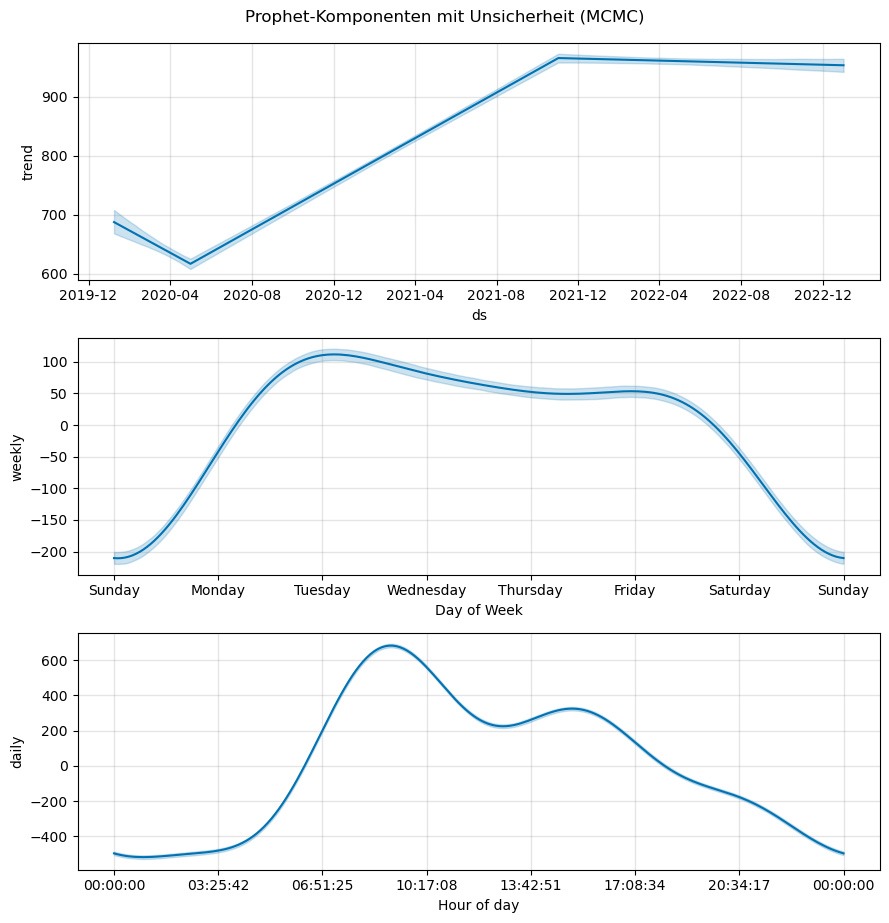

In [5]:
fit_df = df_hourly.dropna(subset=["y"]).copy()

# ZELLE G: Prophet mit MCMC-Samples (Unsicherheiten nach Vorgabe)
m_mcmc = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=0.1,
    seasonality_mode="additive",
    interval_width=0.95,
    mcmc_samples=500,        # ggf. 300–1000 je nach Rechenzeit
    uncertainty_samples=100,
    changepoints=['2021-11-01', '2020-05-01'],
    n_changepoints=2
)

m_mcmc.fit(fit_df[["ds","y"]])
fc_mcmc = m_mcmc.predict(fit_df[["ds"]])

fit_df["yhat_mcmc"] = fc_mcmc["yhat"].values
fit_df["resid_mcmc"] = fit_df["y"] - fit_df["yhat_mcmc"]

# Komponentenplots mit Unsicherheiten
_ = m_mcmc.plot_components(fc_mcmc)
plt.suptitle("Prophet-Komponenten mit Unsicherheit (MCMC)", y=1.02)
plt.show()

Die Trendkurve (oberer
Plot) zeigt einen linear fallenden Verlauf bis Mai 2020, einen linear steigenden Verlauf
bis November 2021 und einen leicht linear fallenden Verlauf bis Ende 2022. Zu sehen ist
die Grundlast in kW. Die Änderungszeitpunkte der Steigung stimmen mit den gesetzten
Changepoints überein und reflektieren die adaptieren Trendverläufe nach Inbetriebnahme
der jeweiligen Gebäude. Dabei scheint das Gebäude im Mai 2020 einen vergleichsweisen
starken Einfluss zu nehmen: Der zuvor negativ gerichtete Trend wird einen positiv wachsenden
Trend verkehrt, was vermuten lässt, dass das Gebäude einen signifikant höheren
Verbrauch bewirkt. Überraschenderweise stabilisiert sich der langfristige Verbrauch mit
Inbetriebnahme des zweiten Gebäudes. Hierbei muss betont werden, dass die neuen Gebäude
nicht ursächlich für die Trendwechsel se

Der wöchentliche saisonale Anteil zeigt einen arbeitstypischen Wochenverlauf, wobei
der additive Effekt in kW je Wochentag sichtbar ist. An Wochenenden liegen durchschnittliche
wöchentliche Saisonanteile bei negativen Werten, sind dort also unter dem
Wochenmittel (Mittel liegt auf 0). An Werktagen ist der Anteil überdurchschnittlich, wobei
am Dienstag das Maximum vorliegt. Am Donnerstag und Freitag pendelt sich der
Anteil auf einem relativ konstanten Niveau ein. Die Tagessaisonalität zeigt eine ähnliche
Charakteristik, wobei sich die Zeitauflösung unterscheidet. Wie zu erwarten ist, ergibt
sich hier ein unterdurchschnittlicher Anteil während der Abend-, Nacht- und frühen Morgenstunden.
Am späten Morgen/frühen Vormittag wird der Tagesanteil maximal, sinkt
während der Mittagszeit etwas ab, bevor er nachmittags ein lokales Maximum durchläuft.
Insgesamt sind die Unsicherheitsbänder der Signalanteile schmal, was auf ein hinreichend
hohes Sampling des MCMC-Verfahrens hinweist.in müssen.

## Zelle H — In-Sample Prognose & Residuen-Auswahl

In [6]:
residuals = fit_df[["ds","y","yhat_mcmc"]].copy()
residuals["resid"] = fit_df["resid_mcmc"]

residuals = residuals.dropna(subset=["resid"]).reset_index(drop=True)
print(residuals.head())
residuals.describe()

                   ds     y   yhat_mcmc       resid
0 2020-01-08 00:00:00  14.0  271.117217 -257.117217
1 2020-01-08 01:00:00   4.0  248.172504 -244.172504
2 2020-01-08 02:00:00   4.0  257.801101 -253.801101
3 2020-01-08 03:00:00   4.0  271.885005 -267.885005
4 2020-01-08 04:00:00  64.0  307.210014 -243.210014


,ds,y,yhat_mcmc,resid
count,26136,26136.000000,26136.000000,26136.000000
mean,2021-07-05 11:30:00,842.329201,842.189879,0.139323
min,2020-01-08 00:00:00,0.000000,-111.335950,-1670.053706
25%,2020-10-06 05:45:00,414.000000,505.866349,-201.572353
50%,2021-07-05 11:30:00,812.000000,845.395446,-57.300801
75%,2022-04-03 17:15:00,1208.000000,1183.013646,126.534250
max,2022-12-31 23:00:00,2948.000000,1754.109541,1461.805806
std,NaN,509.774221,413.317582,298.165920


## Zelle J — Residuen-Histogramm & QQ-Plot

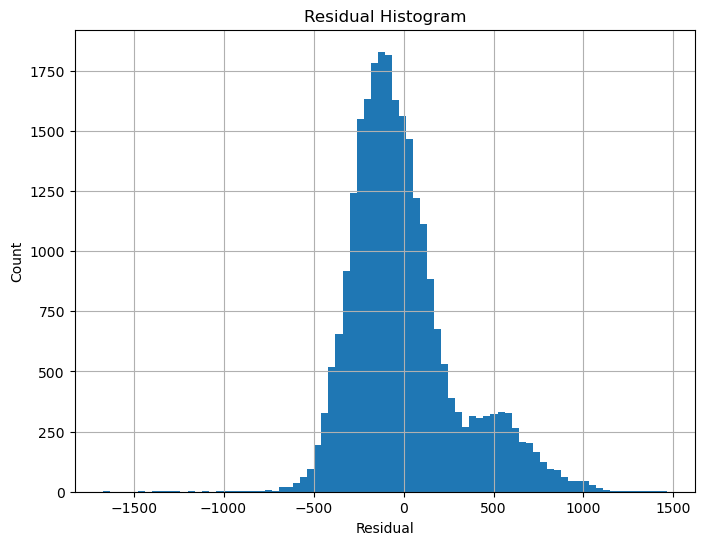

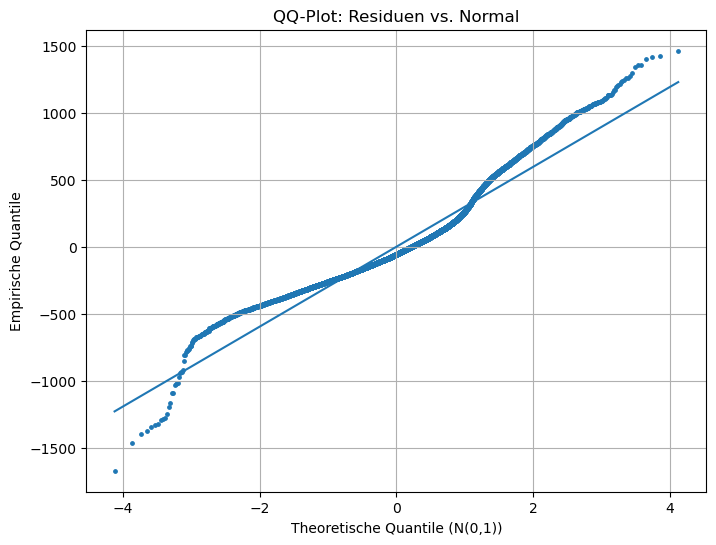

In [7]:
# ZELLE J: Histogramm & QQ-Plot
fig = plt.figure()
plt.hist(residuals["resid"].values, bins=80, edgecolor="none")
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

r = np.sort(residuals["resid"].values)
m = len(r)
theo = norm.ppf((np.arange(1, m+1)-0.5)/m)
slope = residuals["resid"].std(ddof=1)
intercept = residuals["resid"].mean()
plt.scatter(theo, r, s=6)
xline = np.linspace(theo.min(), theo.max(), 200)
plt.plot(xline, intercept + slope * xline)
plt.title("QQ-Plot: Residuen vs. Normal")
plt.xlabel("Theoretische Quantile (N(0,1))")
plt.ylabel("Empirische Quantile")
plt.show()

--> klar nicht normalverteilt. Daher residuen mittels quantilen berechnet (d.h. nicht parametrisch).

Klar 
erkennbar ist die Rechtsschiefe der Verteilung, weswegen die Annahme normalverteilter
Residuen nicht haltbar ist. Die Abweichung von der Normalverteilung wird auch im QQPlot
ersichtlich, der starke Abweichungen an den Flanken aufze. Damit
ist die Identifikation von Ausreissern auf Basis der Standardabweichung keine aussagekräftige
Methode. Parametrische Schätzungen auf Grundlage von Konfidenz und Signifikanzniveaus
gehen mit dem Risiko von Verzerrungen einher. Folglich bieten sich nicht
parametrische Kriterien auf Grundlage von Quantilen an. Die Bestimmung von Lagemassen
wie Median, 25%-Quartil und 75%-Quartil erfordert keine Normalverteilung. Ausreisser
werden über beidseitige Schwellen 𝑟𝑒𝑠𝑖𝑑􀯧 < 𝑄􀬵 = 0.005 und 𝑟𝑒𝑠𝑖𝑑􀯧 > 𝑄􀬶 =
0.995 ermittelt. Daher werden die 0,5%- und 99,5%-Quartile der Residuenverteilung bestimmt,
die als Grenzwerte für untere (negative) und obere (positive) Schwellenwerte
herangezogen werden.igt

In [8]:
q1, q3 = np.quantile(residuals["resid"].values, [0.005, 0.995])

residuals["is_outlier"] = ((residuals["resid"].values < q1) | (residuals["resid"].values > q3)).astype(int)

residuals["pos_outlier"] = 0
residuals["neg_outlier"] = 0

residuals.loc[residuals["resid"] > q3, "pos_outlier"] = 1
residuals.loc[residuals["resid"] < q1, "neg_outlier"] = 1

residuals.describe()

,ds,y,yhat_mcmc,resid,is_outlier,pos_outlier,neg_outlier
count,26136,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000
mean,2021-07-05 11:30:00,842.329201,842.189879,0.139323,0.010024,0.005012,0.005012
min,2020-01-08 00:00:00,0.000000,-111.335950,-1670.053706,0.000000,0.000000,0.000000
25%,2020-10-06 05:45:00,414.000000,505.866349,-201.572353,0.000000,0.000000,0.000000
50%,2021-07-05 11:30:00,812.000000,845.395446,-57.300801,0.000000,0.000000,0.000000
75%,2022-04-03 17:15:00,1208.000000,1183.013646,126.534250,0.000000,0.000000,0.000000
max,2022-12-31 23:00:00,2948.000000,1754.109541,1461.805806,1.000000,1.000000,1.000000
std,NaN,509.774221,413.317582,298.165920,0.099621,0.070621,0.070621


Für die Quantifizierung der Ausreisserresultate wurden die Dummies
is_outlier, pos_outlier und neg_outlier erzeugt, die jeweils anzeigen, ob ein Datenpunkt
als Ausreisser, positiver Ausreisser bzw. negativer Ausreisser erkannt wi. Wie zu erwarten, erweist sich
1% der Residuen als Ausreisser, die sich näherungsweise zu gleichen Anteilen auf positive
und negative Ausreisser verteilen.rd

## Zelle K — Heatmaps & Monats-Counts (Ausreisser)

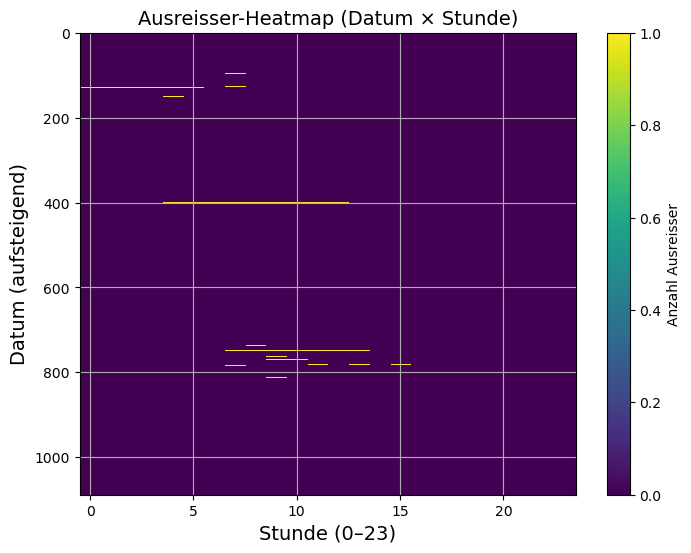

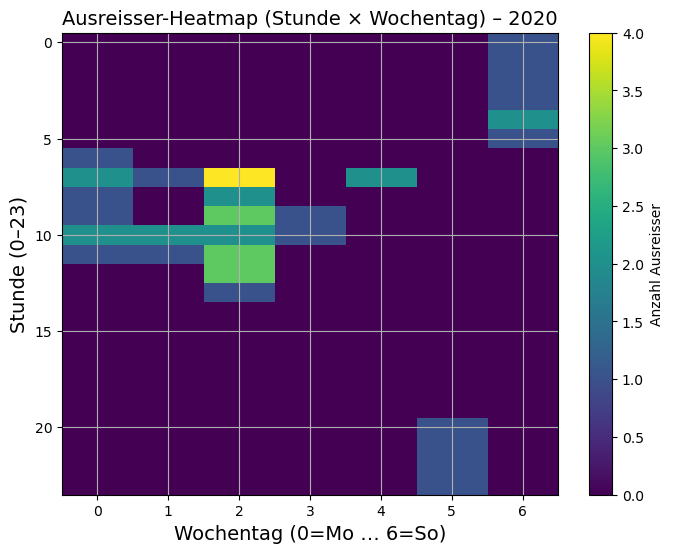

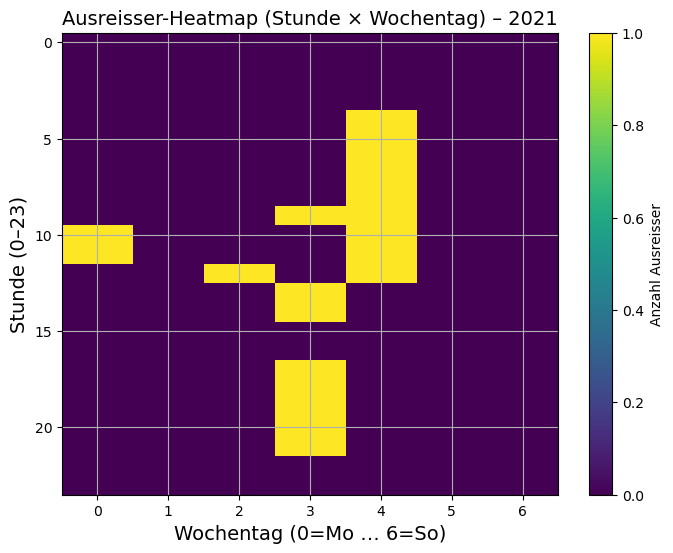

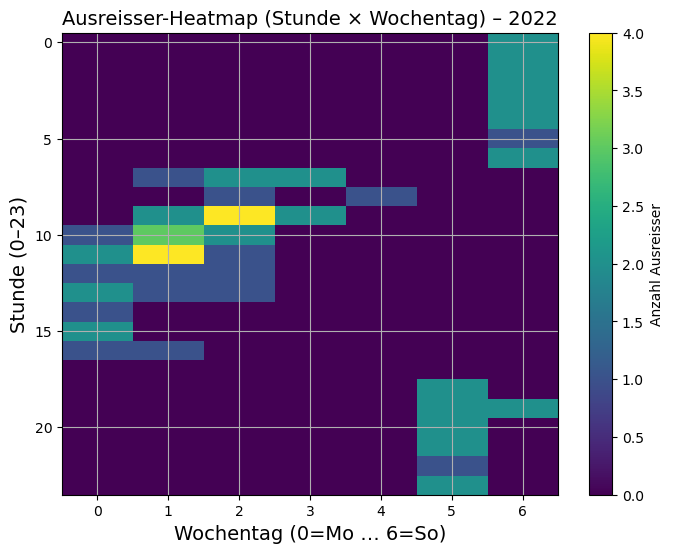

In [9]:
# ZELLE K: Heatmaps & Monats-Counts Positive Outlier
dfh = residuals.copy()
dfh["ds"] = pd.to_datetime(dfh["ds"])
dfh["date"] = dfh["ds"].dt.date
dfh["hour"] = dfh["ds"].dt.hour
dfh["year"] = dfh["ds"].dt.year
dfh["weekday"] = dfh["ds"].dt.weekday  # 0=Mo
dfh["is_outlier"] = dfh["is_outlier"].astype(int)

# 1) Date x Hour Heatmap
pivot_dh = dfh.pivot_table(index="date", columns="hour", values="pos_outlier", aggfunc="sum", fill_value=0)
plt.imshow(pivot_dh.values, aspect="auto", interpolation="nearest")
plt.title("Ausreisser-Heatmap (Datum × Stunde)", fontsize=14)
plt.xlabel("Stunde (0–23)", fontsize=14)
plt.ylabel("Datum (aufsteigend)", fontsize=14)
plt.colorbar(label="Anzahl Ausreisser")
plt.show()

# 2) Hour x Weekday für jedes Jahr
for y in sorted(dfh["year"].unique()):
    sub = dfh[dfh["year"]==y]
    if sub.empty:
        continue
    pivot_hw = sub.pivot_table(index="hour", columns="weekday", values="pos_outlier", aggfunc="sum", fill_value=0)
    plt.imshow(pivot_hw.values, aspect="auto", interpolation="nearest")
    plt.title(f"Ausreisser-Heatmap (Stunde × Wochentag) – {y}", fontsize=14)
    plt.xlabel("Wochentag (0=Mo … 6=So)", fontsize=14)
    plt.ylabel("Stunde (0–23)", fontsize=14)
    plt.colorbar(label="Anzahl Ausreisser")
    plt.show()

Die Datenpunkte
repräsentieren die Anzahl an Ausreisseren in dem betreffenden Monat. Auffällig ist die
deutliche Heterogenität der Häufigkeiten: Einige Monate zeigen keine Ausreisser, während
andere ausgeprägte Ausschläge aufweisen.

Im Februar 2022 wurden über 30 positive
Ausreisser ausgemacht (Maximum)

Bei der Interpretation der Daten ist zu beachten, dass Monatslängen
sich unterscheiden. Weiterhin ist der Januar 2021 verzerrt, da die Daten am 08.01.2020
starten..

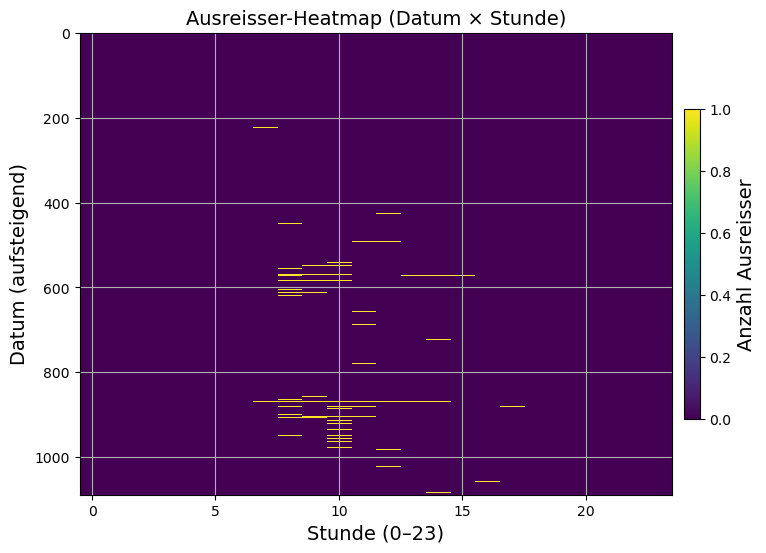

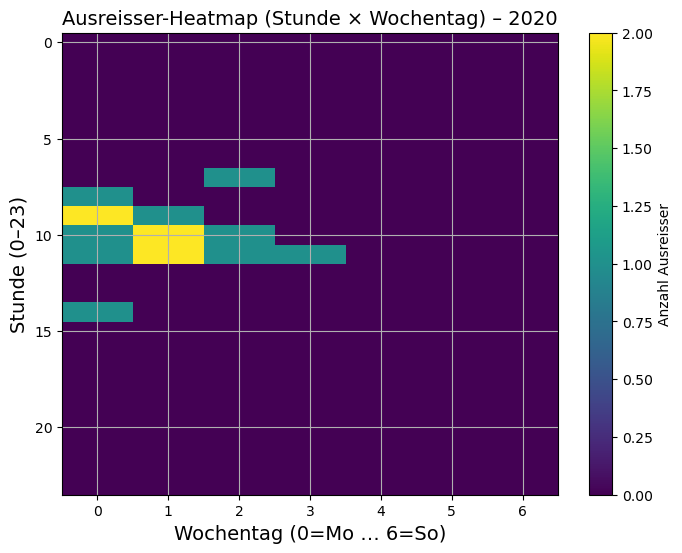

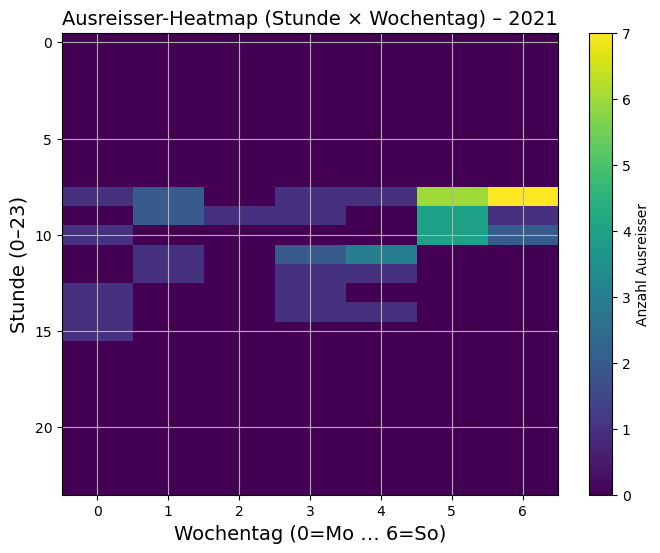

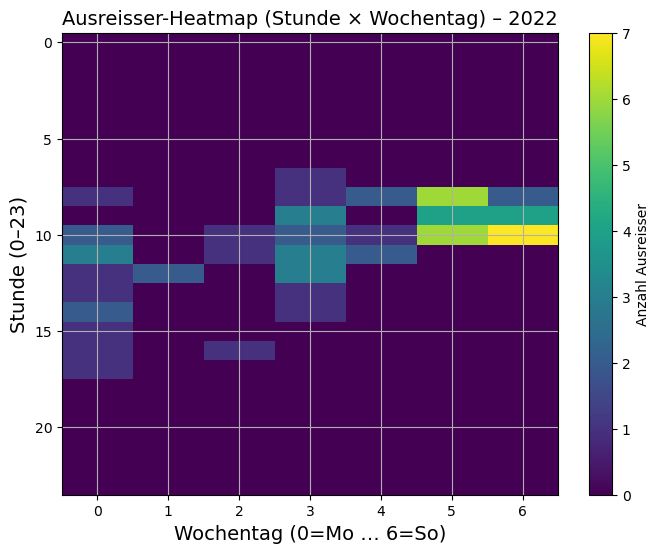

In [10]:
# ZELLE K: Heatmaps & Monats-Counts Negative Outlier (
dfh = residuals.copy()
dfh["ds"] = pd.to_datetime(dfh["ds"])
dfh["date"] = dfh["ds"].dt.date
dfh["hour"] = dfh["ds"].dt.hour
dfh["year"] = dfh["ds"].dt.year
dfh["weekday"] = dfh["ds"].dt.weekday  # 0=Mo
dfh["is_outlier"] = dfh["is_outlier"].astype(int)

# 1) Date x Hour Heatmap
pivot_dh = dfh.pivot_table(index="date", columns="hour", values="neg_outlier", aggfunc="sum", fill_value=0)
plt.imshow(pivot_dh.values, aspect="auto", interpolation="nearest")
plt.title("Ausreisser-Heatmap (Datum × Stunde)", fontsize=14)
plt.xlabel("Stunde (0–23)", fontsize=14)
plt.ylabel("Datum (aufsteigend)", fontsize=14)
cbar = plt.colorbar(fraction=0.025, pad=0.02)
cbar.set_label(label="Anzahl Ausreisser", fontsize=14)
plt.show()

# 2) Hour x Weekday für jedes Jahr
for y in sorted(dfh["year"].unique()):
    sub = dfh[dfh["year"]==y]
    if sub.empty:
        continue
    pivot_hw = sub.pivot_table(index="hour", columns="weekday", values="neg_outlier", aggfunc="sum", fill_value=0)
    plt.imshow(pivot_hw.values, aspect="auto", interpolation="nearest")
    plt.title(f"Ausreisser-Heatmap (Stunde × Wochentag) – {y}", fontsize=14)
    plt.xlabel("Wochentag (0=Mo … 6=So)", fontsize=14)
    plt.ylabel("Stunde (0–23)", fontsize=14)
    plt.colorbar(label="Anzahl Ausreisser")
    plt.show()

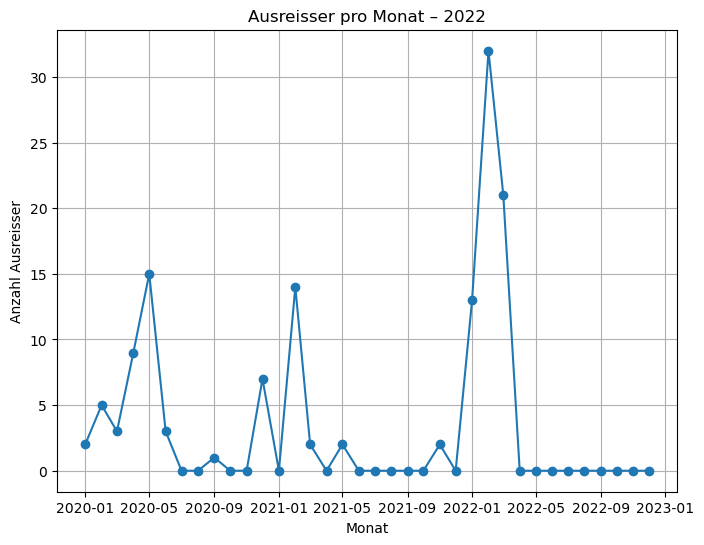

In [11]:
sub = dfh.copy()
sub["month"] = sub["ds"].dt.to_period("M")
monthly = sub.groupby("month")["pos_outlier"].sum()
monthly.index = monthly.index.to_timestamp()
plt.plot(monthly.index, monthly.values, marker="o")
plt.title(f"Ausreisser pro Monat – {y}")
plt.xlabel("Monat")
plt.ylabel("Anzahl Ausreisser")
plt.show()

Die Datenpunkte
repräsentieren die Anzahl an Ausreisseren in dem betreffenden Monat. Auffällig ist die
deutliche Heterogenität der Häufigkeiten: Einige Monate zeigen keine Ausreisser, während
andere ausgeprägte Ausschläge aufwei.

Das Maximum für negative Ausreisser findet sich
mit 20 im August. Bei der Interpretation der Daten ist zu beachten, dass Monatslängen
sich unterscheiden. Weiterhin ist der Januar 2021 verzerrt, da die Daten am 08.01.2020
startensen

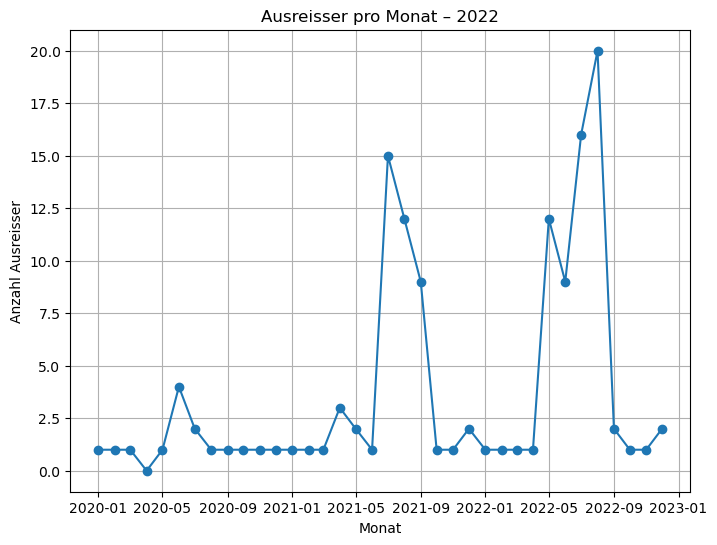

In [12]:
sub = dfh.copy()
sub["month"] = sub["ds"].dt.to_period("M")
monthly = sub.groupby("month")["neg_outlier"].sum()
monthly.index = monthly.index.to_timestamp()
plt.plot(monthly.index, monthly.values, marker="o")
plt.title(f"Ausreisser pro Monat – {y}")
plt.xlabel("Monat")
plt.ylabel("Anzahl Ausreisser")
plt.show()

## Zelle N — Interpretations-Template

In [13]:
# ZELLE N: Interpretation (Template)
from textwrap import dedent
txt = dedent(f"""
Interpretation – Kurzfassung
----------------------------
Trend & Changepoints:
- Gebäude-Inbetriebnahmen am 2020-01-01 und 2021-01-01 als Regressoren modelliert.
- Trend/Level: [DEIN KOMMENTAR], Level-Shifts plausibel / [ANPASSEN].

Saisonalitäten:
- Daily: Spitzen um [xx] Uhr; Nachtabsenkung [ja/nein]. Unsicherheitsbänder aus MCMC plausibel?
- Weekly: Werktags-/Wochenend-Muster: [DEIN KOMMENTAR].

Residuen:
- Std-Abw: {diag.get('std_resid', None)}
- Schiefe: {diag.get('skew', None)}; Kurtosis: {diag.get('kurtosis', None)}
- Jarque-Bera: Stat={diag.get('jarque_bera_stat', None)}, p={diag.get('jarque_bera_p', None)}
- Outlier-Methode: {diag.get('method_outliers', 'n/a')} mit Schwellen [{diag.get('thr_low','n/a')}, {diag.get('thr_high','n/a')}].

Ausreisser-Muster:
- Heatmaps zeigen Cluster bei [Stunden/Wochentagen/Monaten].
- Monats-Counts: Auffällig in [Monate/Jahre] (Ferien/Feiertage/Betrieb/Wetter/Messfehler?).

Zufälligkeit:
- Runs-Test: Z ≈ [siehe Zelle L]. |Z| gross → Nicht-Zufälligkeit; klein → mit Zufall vereinbar.

Fazit:
- Modell ergibt [Sinn/Nachschärfung nötig].
- Empfehlungen: [Alarm-Schwellen], [Daten-Qualität], [weitere Regressoren: Feiertage/Wetter], etc.
""")
print(txt)

NameError: name 'diag' is not defined